# ML MT2016 Project: Cats vs Dogs

## FINISH THIS
We attempt to train neural networks to distinguish between cats and dogs from the corresponding [open dataset](https://www.kaggle.com/c/dogs-vs-cats) on Kaggle.

The TensorFlow tutorials, howtos and example code (particularly that on [reading data](https://www.tensorflow.org/how_tos/reading_data/)), were used as guidance on code design and data handling, but not network design.

## The Data
The input data consists of 25000 labelled images of cats and dogs (half of each). We also have an additional 12500 unlabelled images for classification and submission to Kaggle's public leaderboard. The images are of variable size, so all have been rescaled to 100 pixels in width and height. This transformation was done without regard for aspect ratio under the assumption that it's hard to stretch cats into dogs or vice versa. Finally the labelled data was split into train, validation and test sets and saved into TensorFlow `.tfrecord` files.

The labels are encoded as:

| label | encoding |
|-------|----------|
| cat | 0 |
| dog | 1 |

## The Models
### Fully Connected Network
 We first use a basic multilayer perceptron as a proof of concept. d will not spend a lot of time optimizing the hyperparameters or network structure since we do not expect the network architecture architecture to be well suited to computer vision anyway. Indeed, once trained, we only achieve about 60% test accuracy with this model.

### Convolutional Network
Next, we add some convolution layers, which are more suited to image recognition.

### Transfer Learning
Finally, we achieve ~X% using transfer learning. While we do not have sufficient computing power or problem specific training data to train a deep convolutional network, we can retrain the final layer of an existing network, such as Google's [Inception-v3](https://github.com/tensorflow/models/tree/master/inception) network trained on [ImageNet](http://image-net.org).

## Setup

Here we load necessary libraries, including our own helper modules: `dataset`, which provides some information (dimensions, length, etc.) about the input data and `tfutil` which provides some utility functions to make working with TensorFlow easier. We also import global flags from `dataset` and set a few more as necessary.

In [2]:
from math import ceil
import os.path

%matplotlib notebook
import matplotlib.pyplot as plt
import tensorflow as tf

import dataset
import tfutil as tfu

from dataset import FLAGS
FLAGS['LOGDIR'] = './logs/'

## Data Handling

These functions handle reading data from the TFRecord files and providing it in randomized batches for stochastic optimization.

In [3]:
def raw_inputs(name='test', num_epochs=1):
    file_queue = tf.train.string_input_producer([os.path.join(FLAGS['DATA_DIR'], name+'.tfrecords')], num_epochs=num_epochs)
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(file_queue)
    features = tf.parse_single_example(serialized_example, features={
        'image_raw': tf.FixedLenFeature([], tf.string),
        'label': tf.FixedLenFeature([], tf.int64),
    })
    image = tf.decode_raw(features['image_raw'], tf.uint8)
    image.set_shape(dataset.image_len())
    label = tf.cast(features['label'], tf.float32)
    return image, label

def inputs(name='train', batch_size=50, num_epochs=1, display=False):
    image, label = raw_inputs(name, num_epochs)
    
    # setting display=True disables centering and normalisation so images can be correctly displayed
    if not display:
        image = tf.cast(image, tf.float32) * (1./255) - 0.5
    
    images, labels = tf.train.shuffle_batch([image, label], batch_size=batch_size, capacity=1000+3*batch_size, min_after_dequeue=1000)
    labels = tf.reshape(labels, [batch_size, 1])
    return images, labels

## A Look at the Data
To check the data was read correctly, we display a random sample of training images.

In [4]:
tf.reset_default_graph()

with tf.Session() as sess:
    images, labels = inputs(name='test', batch_size=16, display=True)
    
    tf.global_variables_initializer().run()
    tf.local_variables_initializer().run()
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    sample_images, sample_labels = sess.run([images, labels])
    sample_labels = sample_labels.reshape([16])
    
    coord.request_stop()
    coord.join(threads)

<IPython.core.display.Javascript object>


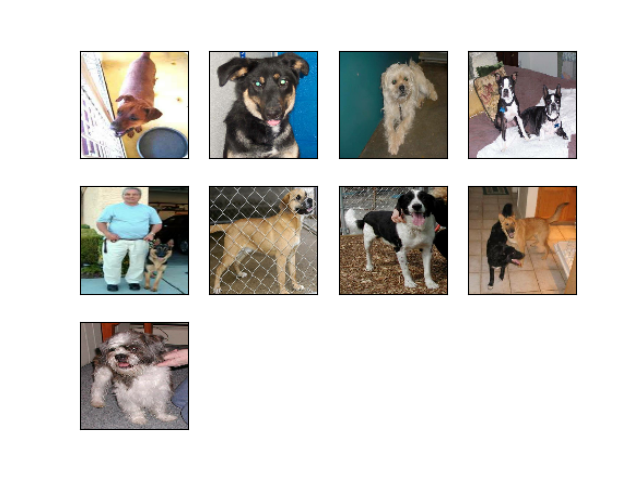

<IPython.core.display.Javascript object>


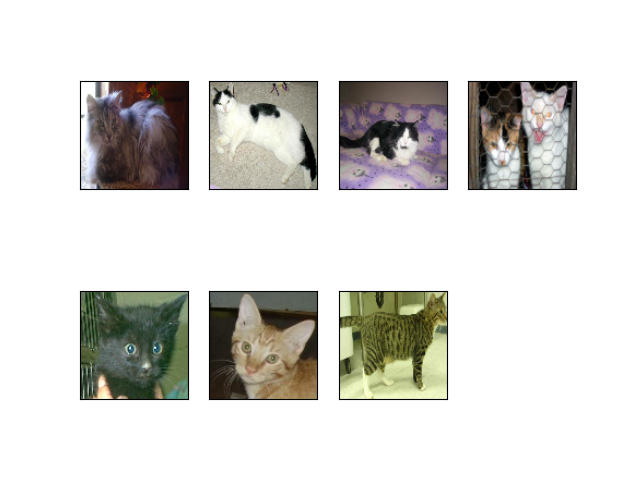

In [5]:
sample_cats = sample_images[sample_labels == 1]
sample_dogs = sample_images[sample_labels == 0]

cat_figure = plt.figure()
for i in range(len(sample_cats)):
    sub = cat_figure.add_subplot(ceil(len(sample_cats)/4), 4, i+1)
    
    # disable axes markings
    sub.set_xticks(())
    sub.set_yticks(())
    
    sub.imshow(sample_cats[i].reshape(dataset.image_dim(include_channels=True)))
cat_figure.show()

dog_figure = plt.figure()
for i in range(len(sample_dogs)):
    sub = dog_figure.add_subplot(ceil(len(sample_dogs)/4), 4, i+1)
    
    # disable axes markings
    sub.set_xticks(())
    sub.set_yticks(())
    
    sub.imshow(sample_dogs[i].reshape(dataset.image_dim(include_channels=True)))
dog_figure.show()

## Training Helper Functions

The following functions are generic and independent of the particular network we want to train. Given a set of training labels and the computed logits (both in the form of TensorFlow graphs/nodes), the first three add to the graph respectively a loss calculation, an accuracy calculation and a training step.

Finally, `do_training` runs the graph created by the previous functions.

In [6]:
def loss_op(logits, labels):
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels, name='xentropy')
    cross_entropy_avg = tf.reduce_mean(cross_entropy, name='xentropy_avg')
    tf.summary.scalar('cross_entropy_avg', cross_entropy_avg)
    return cross_entropy_avg

def accuracy_op(logits, labels):
    correct_prediction = tf.equal(tf.greater(logits, 0.5), tf.greater(labels, 0.5))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', accuracy)
    return accuracy

def train_op(loss, learning_rate):
    global_step = tf.Variable(0, name='global_step', trainable=False)
    return tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)

def do_training(logits, labels, logdir):
    loss = loss_op(logits, labels)
    accuracy = accuracy_op(logits, labels)
    train = train_op(loss, learning_rate=1e-4)
    
    summary_op = tf.summary.merge_all()
    
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    
    print('Creating session.')
    # create session and summary writer
    sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
    log_writer = tf.summary.FileWriter(logdir=os.path.join(FLAGS['LOGDIR'], logdir), graph=sess.graph)
    
    print('Running training.')
    # run ops
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    try:
        step = 0
        while not coord.should_stop():
            _, summary = sess.run([train, summary_op])
            log_writer.add_summary(summary, global_step=step)

            if step % 100 == 0:
                summary, acc, ce = sess.run([summary_op, accuracy, loss])
                log_writer.add_summary(summary, global_step=step)
                print('Cross Entropy: {ce:.2n}'.format(acc=acc, ce=ce))
                
            if step % 1000 == 0:
                pass
            step += 1
    except tf.errors.OutOfRangeError:
        print('Done training for {} steps.'.format(step))
    finally:
        coord.request_stop()

## Fully Connected

Now we build our first model, a fully connected feed forward network. The first function builds the fully connected inference part of the graph and returns the computed logit (the likelihood the image is a dog). The second runs training on that network using the generic functions above.

In [11]:
def fc_inference_op(images, fc1_nodes, fc2_nodes, fc0_nodes = dataset.image_len()):    
    with tf.name_scope('fc1'):
        weights_fc1 = tfu.normal_weight_variable([fc0_nodes, fc1_nodes])
        bias_fc1 = tfu.constant_bias_variable([fc1_nodes])
        y_fc1 = tf.nn.relu(tf.matmul(images, weights_fc1) + bias_fc1)

    with tf.name_scope('fc2'):
        weights_fc2 = tfu.normal_weight_variable([fc1_nodes, fc2_nodes])
        bias_fc2 = tfu.constant_bias_variable([fc2_nodes])
        y_fc2 = tf.nn.relu(tf.matmul(y_fc1, weights_fc2) + bias_fc2)
    
    with tf.name_scope('out'):
        weights_out = tfu.normal_weight_variable([fc2_nodes, 1])
        bias_out = tfu.constant_bias_variable([1])
        y = tf.matmul(y_fc2, weights_out) + bias_out
    
    return y

def do_fc(total_epochs, fc1_nodes=64, fc2_nodes=32):    
    print('Building graph.')
    # clear any old nodes
    tf.reset_default_graph()
    
    # build the graph
    images, labels = inputs(name='test', batch_size=50, num_epochs=total_epochs)
    
    logits = fc_inference_op(images, fc1_nodes=64, fc2_nodes=32)
    do_training(logits, labels, logdir='fc')

In [12]:
do_fc(total_epochs=10)

Building graph.
Creating session.
Running training.
Cross Entropy: 1.2
Cross Entropy: 0.59
Cross Entropy: 0.6
Cross Entropy: 0.61
Cross Entropy: 0.52
Cross Entropy: 0.48
Cross Entropy: 0.43
Cross Entropy: 0.35
Done training for 742 steps.


In [ ]:
test_x, test_y = 
test_accuracy = sess.run(accuracy, feed_dict=build_feed_dict(dataset, images, labels, mode='test'))
print('=' * 30)
print('Done.')
print('Test accuracy {acc:.2%}'.format(acc=test_accuracy))

In [43]:
do_fc(total_epochs=10)

Building graph.
Creating session.
Running training.
Train accuracy 36.00%; Cross Entropy 0.93
Train accuracy 46.00%; Cross Entropy 0.77
Train accuracy 36.00%; Cross Entropy 0.72
Train accuracy 62.00%; Cross Entropy 0.61
Train accuracy 60.00%; Cross Entropy 0.52
Train accuracy 70.00%; Cross Entropy 0.59
Train accuracy 74.00%; Cross Entropy 0.53
Train accuracy 72.00%; Cross Entropy 0.53
Train accuracy 64.00%; Cross Entropy 0.58
Train accuracy 76.00%; Cross Entropy 0.53
Train accuracy 86.00%; Cross Entropy 0.41
Train accuracy 84.00%; Cross Entropy 0.47
Train accuracy 78.00%; Cross Entropy 0.44
Train accuracy 74.00%; Cross Entropy 0.52
Train accuracy 84.00%; Cross Entropy 0.43
Done training for 735 steps.


We obtain ~60% accuracy (depending on the run) on the test set, but of course we would like to do a lot better. We will try adding some convolutional layers.

## Convnet

In [9]:
data = Dataset(image_dir='train', image_size=50, conv=True, batch_size=50)

valid_x, valid_y = data.valid_images()
test_x, test_y = data.test_images()

image_shape = data.image_size()

In [10]:
tf.reset_default_graph()

In [11]:
def build_graph():
    x = tf.placeholder(shape=[None, ] + image_shape, dtype=tf.float32, name='features')
    y = tf.placeholder(shape=[None, 1], dtype=tf.float32, name='labels')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')

    CHANNELS = [3, 32, 16]
    CONV1_SIZE = 20
    CONV2_SIZE = 10

    FC1_NODES = 1024
    FC2_NODES = 64

    with tf.name_scope('conv1'):
        weights_conv1 = weight_variable([CONV1_SIZE, CONV1_SIZE, CHANNELS[0], CHANNELS[1]])
        bias_conv1 = bias_variable([CHANNELS[1]])
        h_conv1 = tf.nn.relu(tf.nn.conv2d(x, weights_conv1, strides=[1,2,2,1], padding='SAME'))
        h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    with tf.name_scope('conv2'):
        weights_conv2 = weight_variable([CONV2_SIZE, CONV2_SIZE, CHANNELS[1], CHANNELS[2]])
        bias_conv2 = bias_variable([CHANNELS[2]])
        h_conv2 = tf.nn.relu(tf.nn.conv2d(h_pool1, weights_conv2, strides=[1,1,1,1], padding='SAME'))
        h_pool2 = tf.nn.avg_pool(h_conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        FLAT_IMAGE_SIZE = 7*7*CHANNELS[2]
        h_pool_flat = tf.reshape(h_pool2, [-1, FLAT_IMAGE_SIZE])
    
    with tf.name_scope('fc1'):
        weights_fc1 = weight_variable([FLAT_IMAGE_SIZE, FC1_NODES])
        bias_fc1 = bias_variable([FC1_NODES])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool_flat, weights_fc1) + bias_fc1)

    with tf.name_scope('fc2'):
        weights_fc2 = weight_variable([FC1_NODES, FC2_NODES])
        bias_fc2 = bias_variable([FC2_NODES])
        h_fc2 = tf.nn.relu(tf.matmul(h_fc1, weights_fc2) + bias_fc2)
    
    with tf.name_scope('out'):
        weights_out = weight_variable([FC2_NODES, 1])
        bias_out = bias_variable([1])
        h_fc_dropout = tf.nn.dropout(h_fc2, keep_prob)
        y_lin = tf.matmul(h_fc_dropout, weights_out) + bias_out
        y_out = tf.nn.sigmoid(y_lin)

    cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_lin, labels=y))
    correct_prediction = tf.equal(tf.greater(y_out, 0.5), tf.greater(y, 0.5))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
   
    train_step = tf.train.AdamOptimizer(5e-5).minimize(cross_entropy)

In [12]:
def create_summaries():
    with tf.name_scope('summary'):
        tf.summary.scalar('cross_entropy', cross_entropy)
        tf.summary.scalar('accuracy', accuracy)
    
        summaries = tf.summary.merge_all()
        train_writer = tf.summary.FileWriter(logdir='tf_logs/conv/train', graph=tf.get_default_graph())
        valid_writer = tf.summary.FileWriter(logdir='tf_logs/conv/valid', graph=tf.get_default_graph())

In [13]:
def train():
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    # run train step, except on every 50th iteration
    # where we compute validation error instead
    for i in range(5000):    
        if i % 50 == 0:
            feed_dict = {x: valid_x, y: valid_y, keep_prob: 1.0}
            summary, acc, ce = sess.run([summaries, accuracy, cross_entropy], feed_dict=feed_dict)
            valid_writer.add_summary(summary, global_step=i)
            print('Validation accuracy {acc:.2%}; Cross Entropy {ce:.2n}'.format(acc=acc, ce=ce))
        else:
            batch_x, batch_y = next(data)
            feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5}
            _, summary = sess.run([train_step, summaries], feed_dict=feed_dict)
            train_writer.add_summary(summary, global_step=i)

    print('=' * 46)
    print('Test accuracy {acc:.2%}'.format(acc=sess.run(accuracy, feed_dict={x: test_x, y: test_y, keep_prob: 1.0})))

Validation accuracy 49.50%; Cross Entropy 31
Validation accuracy 57.10%; Cross Entropy 1.4
Validation accuracy 56.40%; Cross Entropy 0.77
Validation accuracy 54.60%; Cross Entropy 0.71
Validation accuracy 52.40%; Cross Entropy 0.7
Validation accuracy 54.40%; Cross Entropy 0.69
Validation accuracy 52.20%; Cross Entropy 0.69
Validation accuracy 53.80%; Cross Entropy 0.68
Validation accuracy 56.30%; Cross Entropy 0.68
Validation accuracy 58.50%; Cross Entropy 0.68
Validation accuracy 58.10%; Cross Entropy 0.67
Validation accuracy 60.00%; Cross Entropy 0.67
Validation accuracy 56.60%; Cross Entropy 0.67
Validation accuracy 60.60%; Cross Entropy 0.67
Validation accuracy 57.20%; Cross Entropy 0.67
Validation accuracy 62.50%; Cross Entropy 0.66
Validation accuracy 55.50%; Cross Entropy 0.67
Validation accuracy 62.80%; Cross Entropy 0.65
Validation accuracy 61.20%; Cross Entropy 0.66
Validation accuracy 62.50%; Cross Entropy 0.65
Validation accuracy 59.80%; Cross Entropy 0.66
Validation accura